Let's discuss about 2 commonly used pruning types.

<br>

***1. Prepruning*** <br>
***2. Postpruning***

<br>

In [4]:
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import tree
from sklearn.metrics import accuracy_score,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt 

In [5]:
data ="D:\\semestre 2 m1glsi\\Fouille de Donnees\\TPValidation\\heart.csv"
df = pd.read_csv(data)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [6]:
X = df.drop(columns=['target'])
y = df['target']
print(X.shape)
print(y.shape)

(303, 13)
(303,)


Splitting dataset to train and test

In [8]:
x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y)
print(x_train.shape)
print(x_test.shape)

(227, 13)
(76, 13)


First we will fit a normal decision tree without any fine tuning and check the results

In [9]:
clf = tree.DecisionTreeClassifier(random_state=0)
clf.fit(x_train,y_train)
y_train_pred = clf.predict(x_train)
y_test_pred = clf.predict(x_test)

### Visualizing decision tree

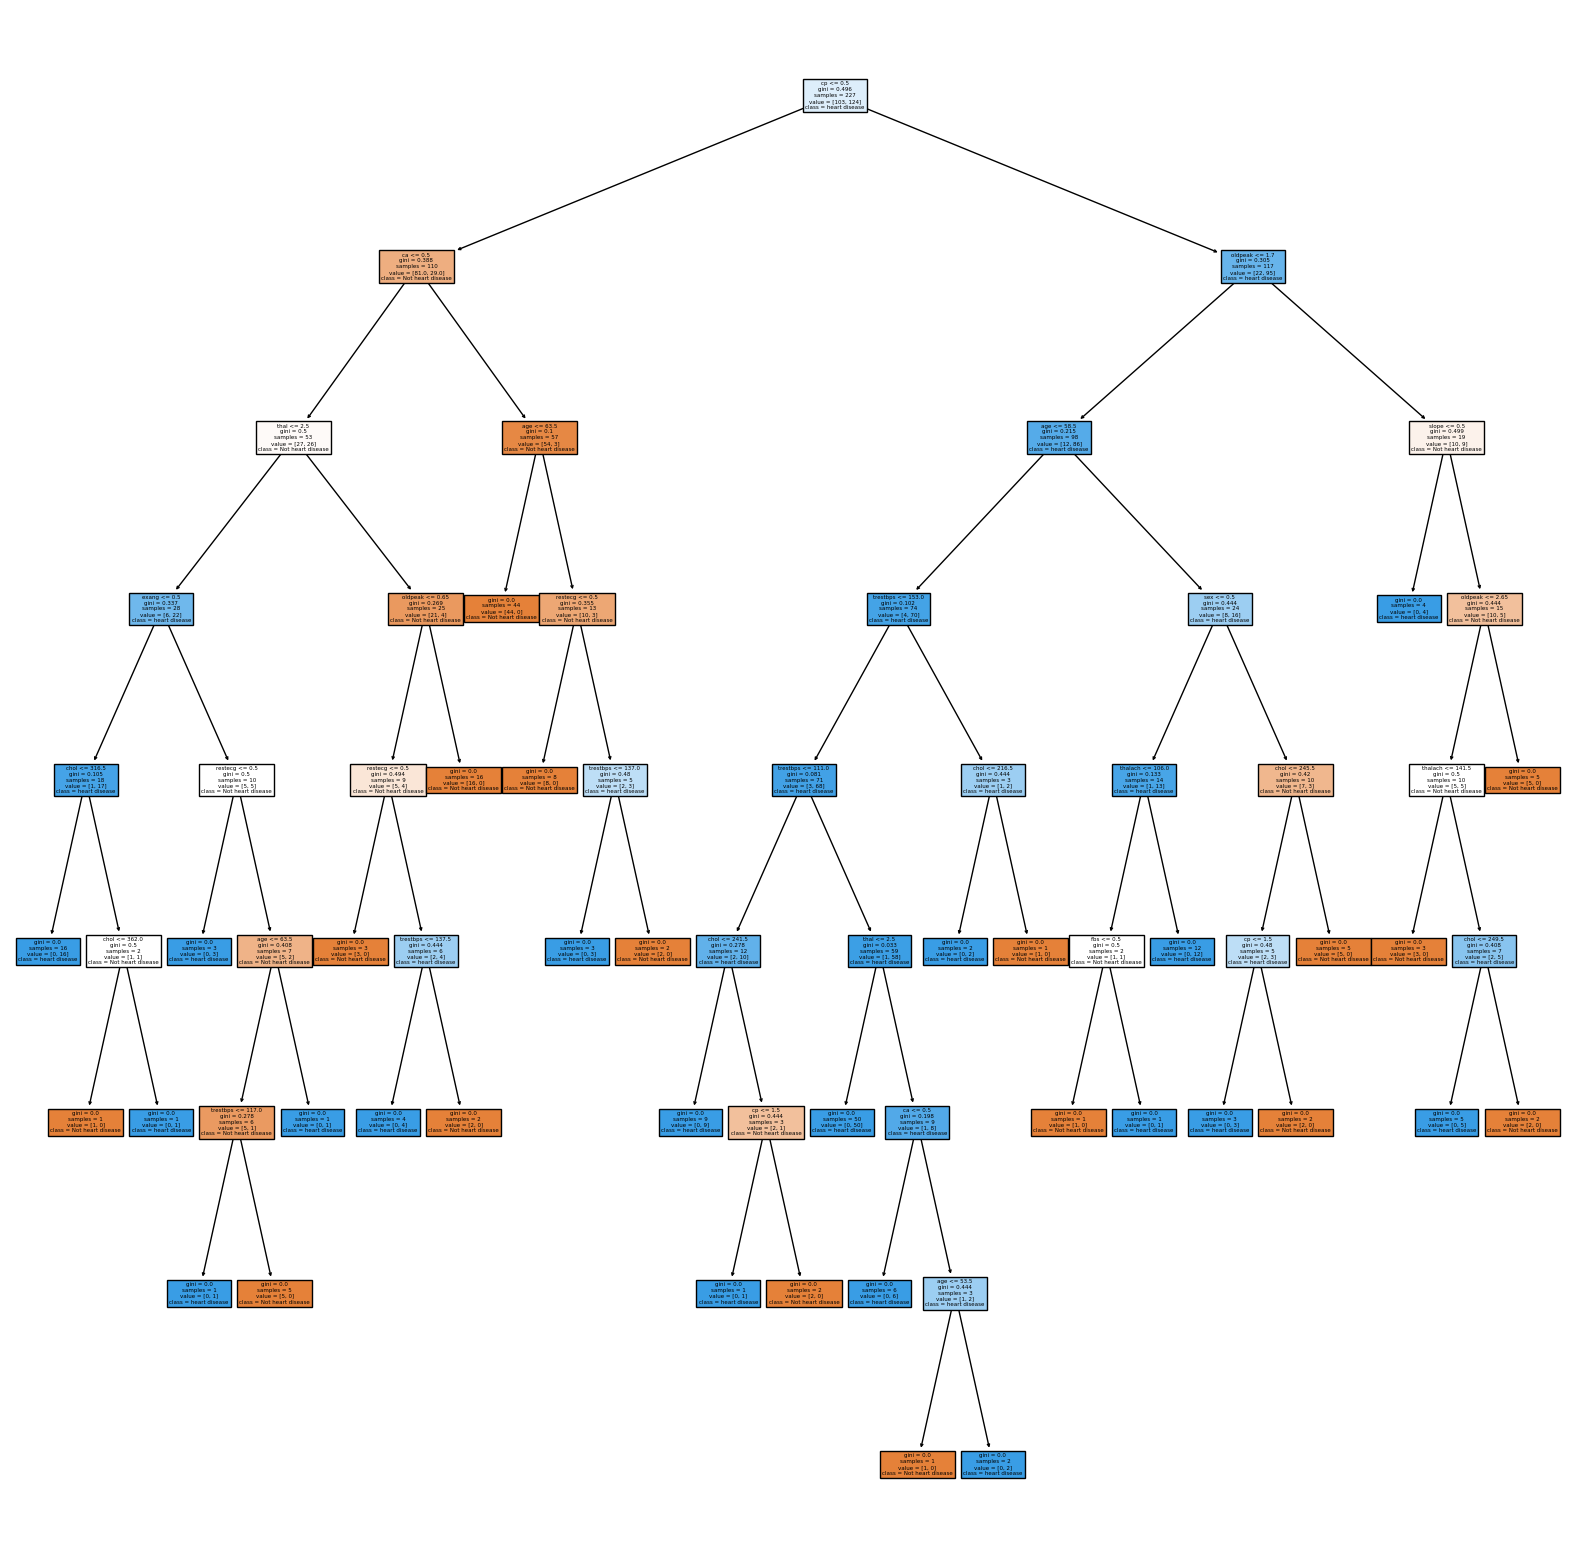

In [10]:
plt.figure(figsize=(20,20))
features = df.columns
classes = ['Not heart disease','heart disease']
tree.plot_tree(clf,feature_names=features,class_names=classes,filled=True)
plt.show()

In [11]:
# helper function
def plot_confusionmatrix(y_train_pred,y_train,dom):
    print(f'{dom} Confusion matrix')
    cf = confusion_matrix(y_train_pred,y_train)
    sns.heatmap(cf,annot=True,yticklabels=classes
               ,xticklabels=classes,cmap='Blues', fmt='g')
    plt.tight_layout()
    plt.show()


Train score 1.0
Test score 0.7105263157894737
Train Confusion matrix


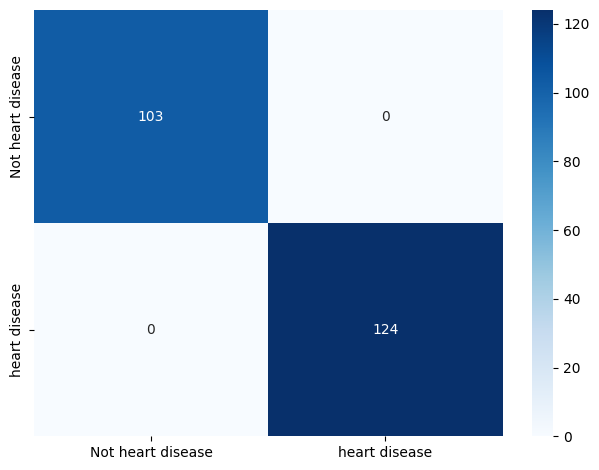

Test Confusion matrix


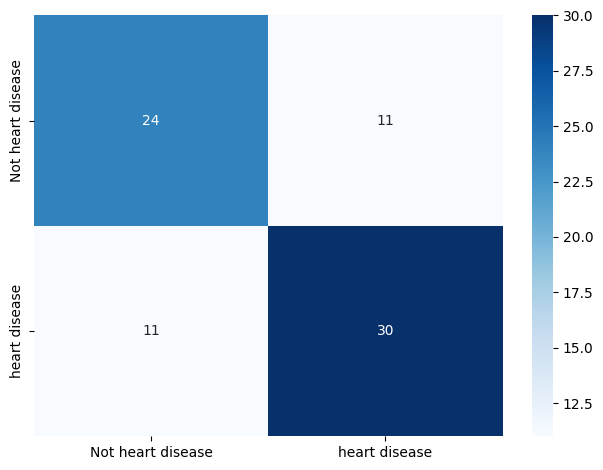

In [12]:
from sklearn.metrics import accuracy_score

print(f'Train score {accuracy_score(y_train_pred, y_train)}')
print(f'Test score {accuracy_score(y_test_pred, y_test)}')

plot_confusionmatrix(y_train_pred, y_train, dom='Train')
plot_confusionmatrix(y_test_pred, y_test, dom='Test')


We can see that in our train data we have 100% accuracy (100 % precison and recall). But in
test data model is not well generalizing. We have just 75% accuracy.
Over model is clearly overfitting. We will avoid overfitting through pruning. We will do cost complexity prunning

## 1. Pre pruning techniques

Pre pruning is nothing but stoping the growth of decision tree on an early stage. For that we can limit the growth of trees by setting constrains. We can limit parameters like *max_depth* , *min_samples* etc.

An effective way to do is that we can grid search those parameters and choose the optimum values that gives better performace on test data.

As of now we will control these parameters
* max_depth: maximum depth of decision tree
* min_sample_split: The minimum number of samples required to split an internal node:
* min_samples_leaf: The minimum number of samples required to be at a leaf node.

In [14]:
params = {'max_depth': [2,4,6,8,10,12],
         'min_samples_split': [2,3,4],
         'min_samples_leaf': [1,2]}

clf = tree.DecisionTreeClassifier()
gcv = GridSearchCV(estimator=clf,param_grid=params)
gcv.fit(x_train,y_train)


GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [2, 4, 6, 8, 10, 12],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3, 4]})

Train score 0.8898678414096917
Test score 0.7105263157894737
Train Confusion matrix


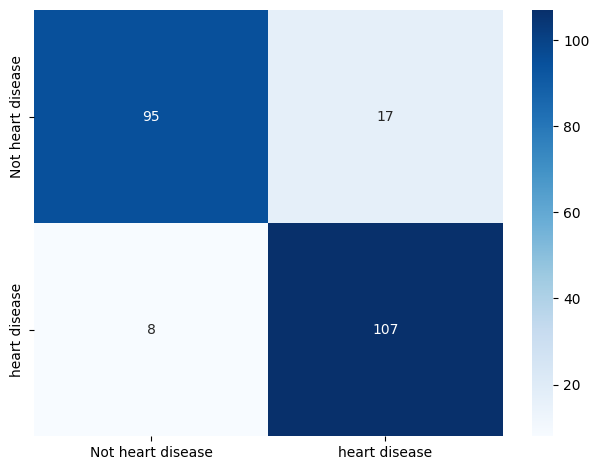

Test Confusion matrix


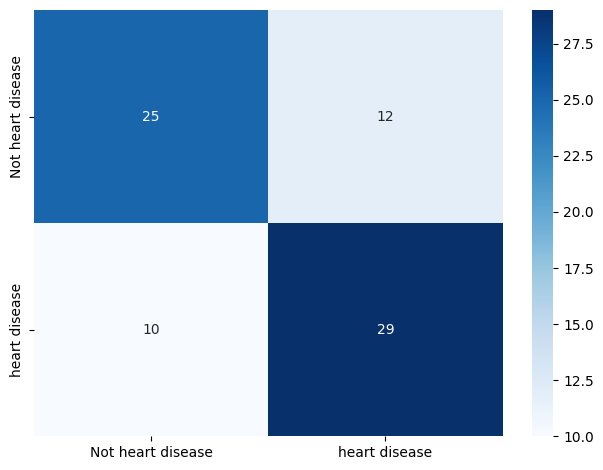

In [15]:
model = gcv.best_estimator_
model.fit(x_train,y_train)
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

print(f'Train score {accuracy_score(y_train_pred,y_train)}')
print(f'Test score {accuracy_score(y_test_pred,y_test)}')
plot_confusionmatrix(y_train_pred,y_train,dom='Train')
plot_confusionmatrix(y_test_pred,y_test,dom='Test')

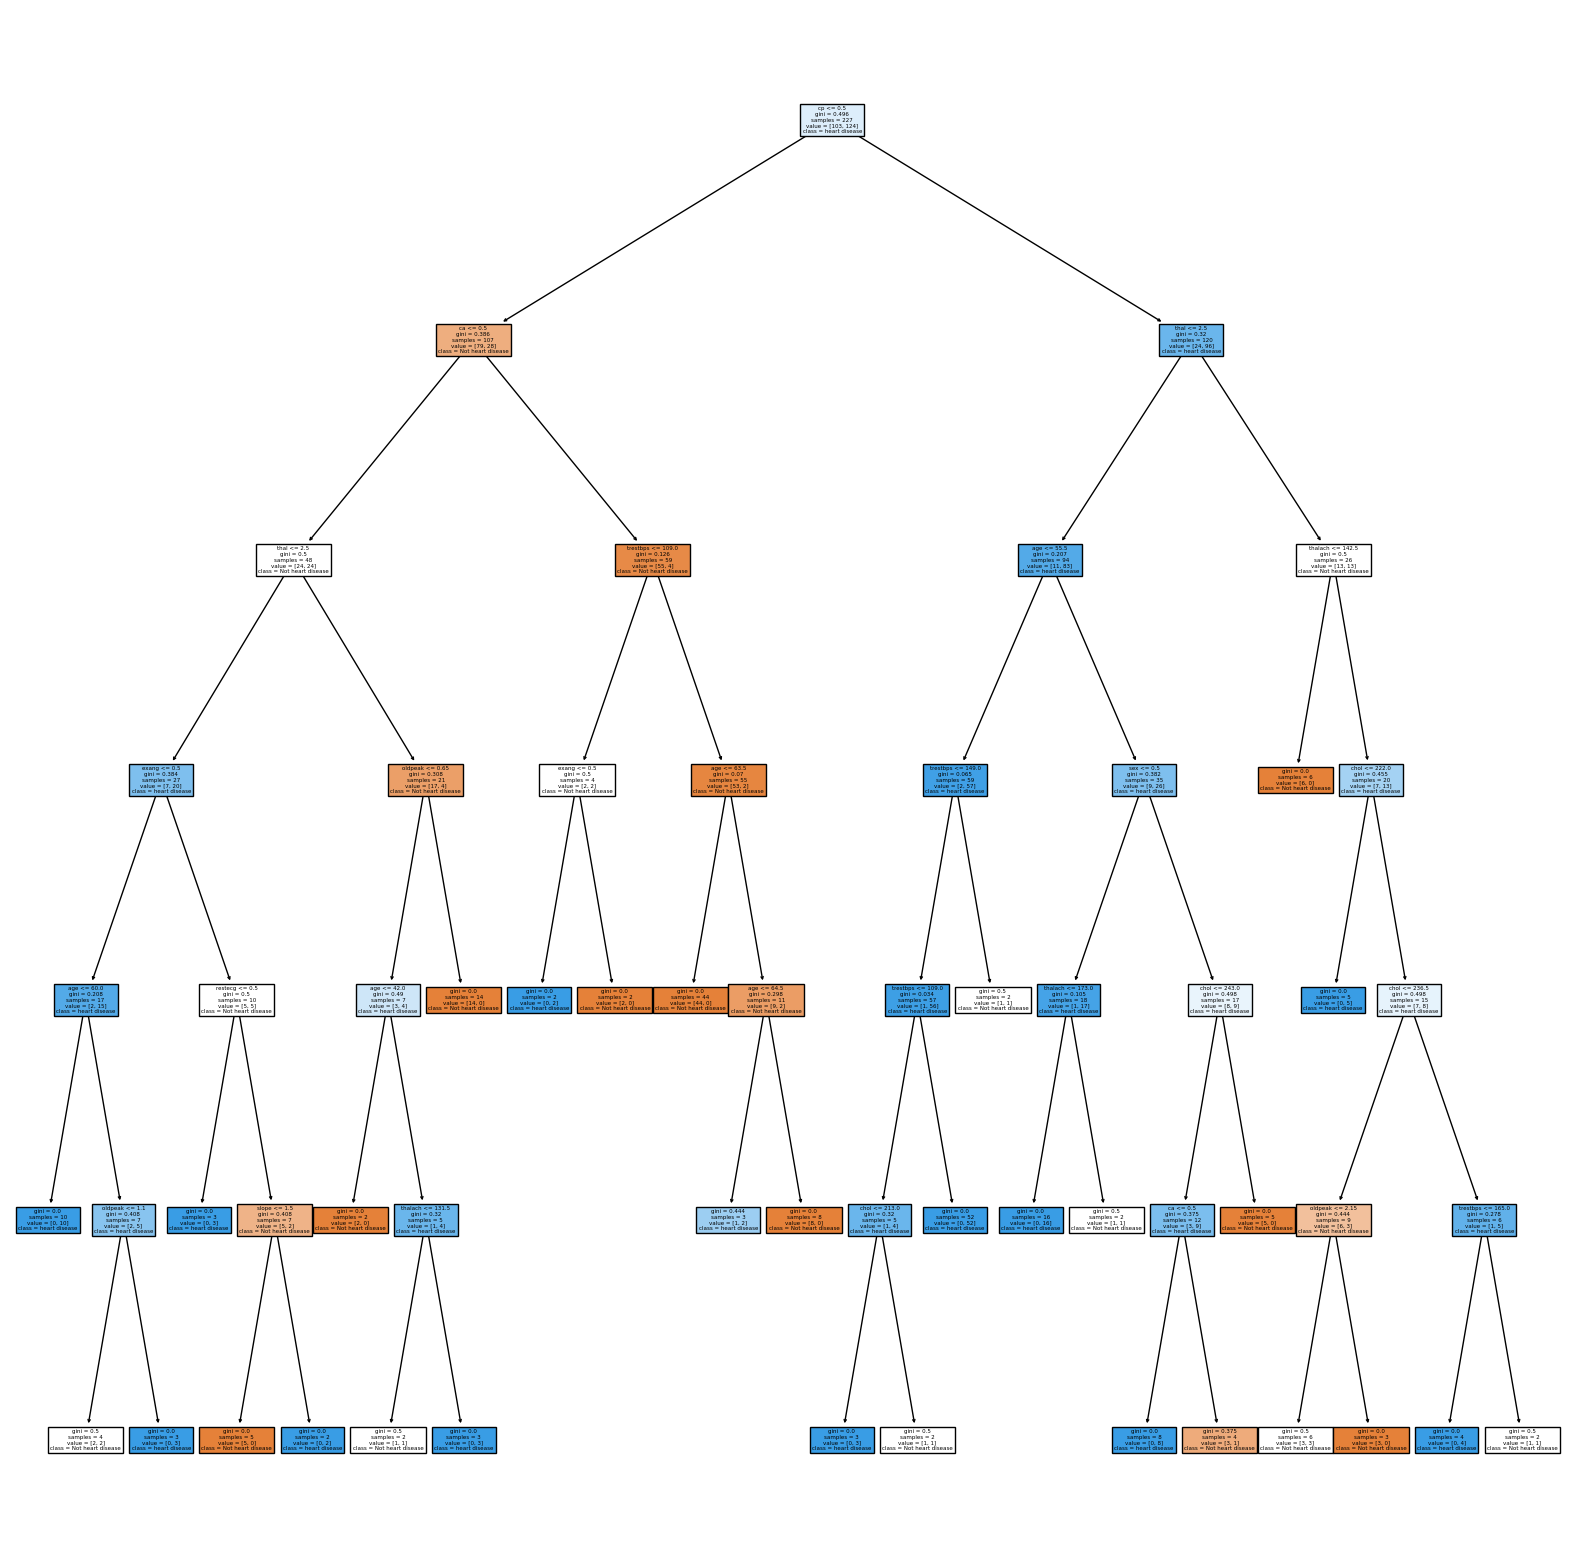

In [12]:
plt.figure(figsize=(20,20))
features = df.columns
classes = ['Not heart disease','heart disease']
tree.plot_tree(model,feature_names=features,class_names=classes,filled=True)
plt.show()

We can see that tree is pruned and there is improvement in test accuracy.But still there is still scope of improvement.

## 2. Post pruning techniques

There are several post pruning techniques. Cost complexity pruning is one of the important among them.

## Cost Complexity Pruning


Decision trees can easily overfit. One way to avoid it is to limit the growth of trees by setting constrains. We can limit parameters like *max_depth* , *min_samples* etc. But a most effective way is to use post pruning methods like cost complexity pruning. This helps to improve test accuracy and get a better model.

Cost complexity pruning is all about finding the right parameter for **alpha**.We will get the alpha values for this tree and will check the accuracy with the pruned trees.



In [16]:
path = clf.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
print(ccp_alphas)

[0.         0.00288708 0.00409062 0.00416055 0.00493521 0.00629327
 0.00834686 0.0092511  0.0094399  0.00978953 0.00978953 0.01002447
 0.01118803 0.01236572 0.01637999 0.02287043 0.04555945 0.04640667
 0.15018964]


In [17]:
# For each alpha we will append our model to a list
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(x_train, y_train)
    clfs.append(clf)


We will remove the last element in clfs and ccp_alphas, because it is the trivial tree with only one node.


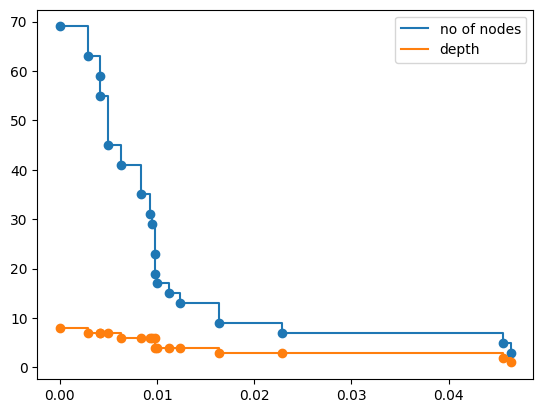

In [18]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
plt.scatter(ccp_alphas,node_counts)
plt.scatter(ccp_alphas,depth)
plt.plot(ccp_alphas,node_counts,label='no of nodes',drawstyle="steps-post")
plt.plot(ccp_alphas,depth,label='depth',drawstyle="steps-post")
plt.legend()
plt.show()

Observation: As alpha increases no of nodes and depth decreases

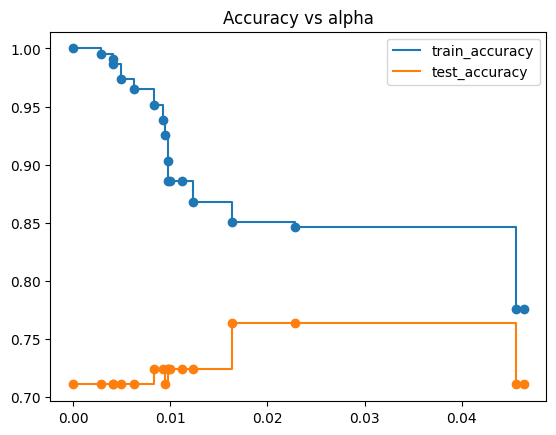

In [19]:
train_acc = []
test_acc = []
for c in clfs:
    y_train_pred = c.predict(x_train)
    y_test_pred = c.predict(x_test)
    train_acc.append(accuracy_score(y_train_pred,y_train))
    test_acc.append(accuracy_score(y_test_pred,y_test))

plt.scatter(ccp_alphas,train_acc)
plt.scatter(ccp_alphas,test_acc)
plt.plot(ccp_alphas,train_acc,label='train_accuracy',drawstyle="steps-post")
plt.plot(ccp_alphas,test_acc,label='test_accuracy',drawstyle="steps-post")
plt.legend()
plt.title('Accuracy vs alpha')
plt.show()

We can choose alpha = 0.020

Train score 0.8502202643171806
Test score 0.7631578947368421
Train Confusion matrix


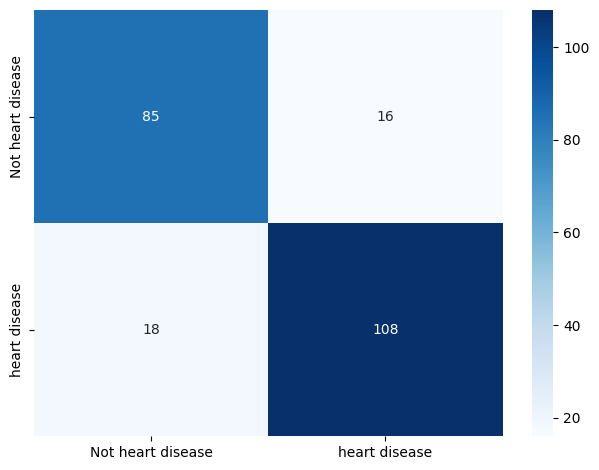

Test Confusion matrix


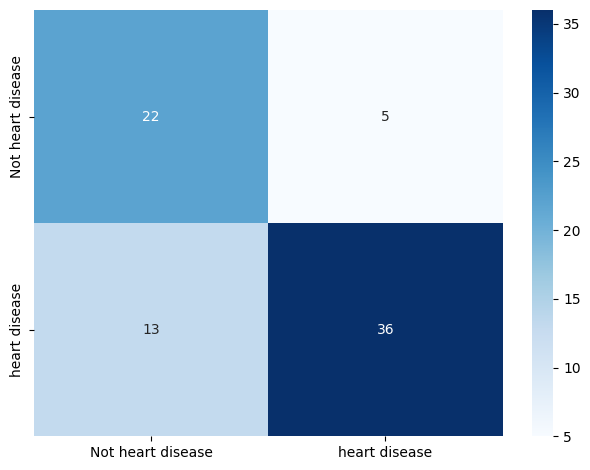

In [20]:
clf_ = tree.DecisionTreeClassifier(random_state=0,ccp_alpha=0.020)
clf_.fit(x_train,y_train)
y_train_pred = clf_.predict(x_train)
y_test_pred = clf_.predict(x_test)

print(f'Train score {accuracy_score(y_train_pred,y_train)}')
print(f'Test score {accuracy_score(y_test_pred,y_test)}')
plot_confusionmatrix(y_train_pred,y_train,dom='Train')
plot_confusionmatrix(y_test_pred,y_test,dom='Test')

We can see that now our model is not overfiting and performance on test data have improved

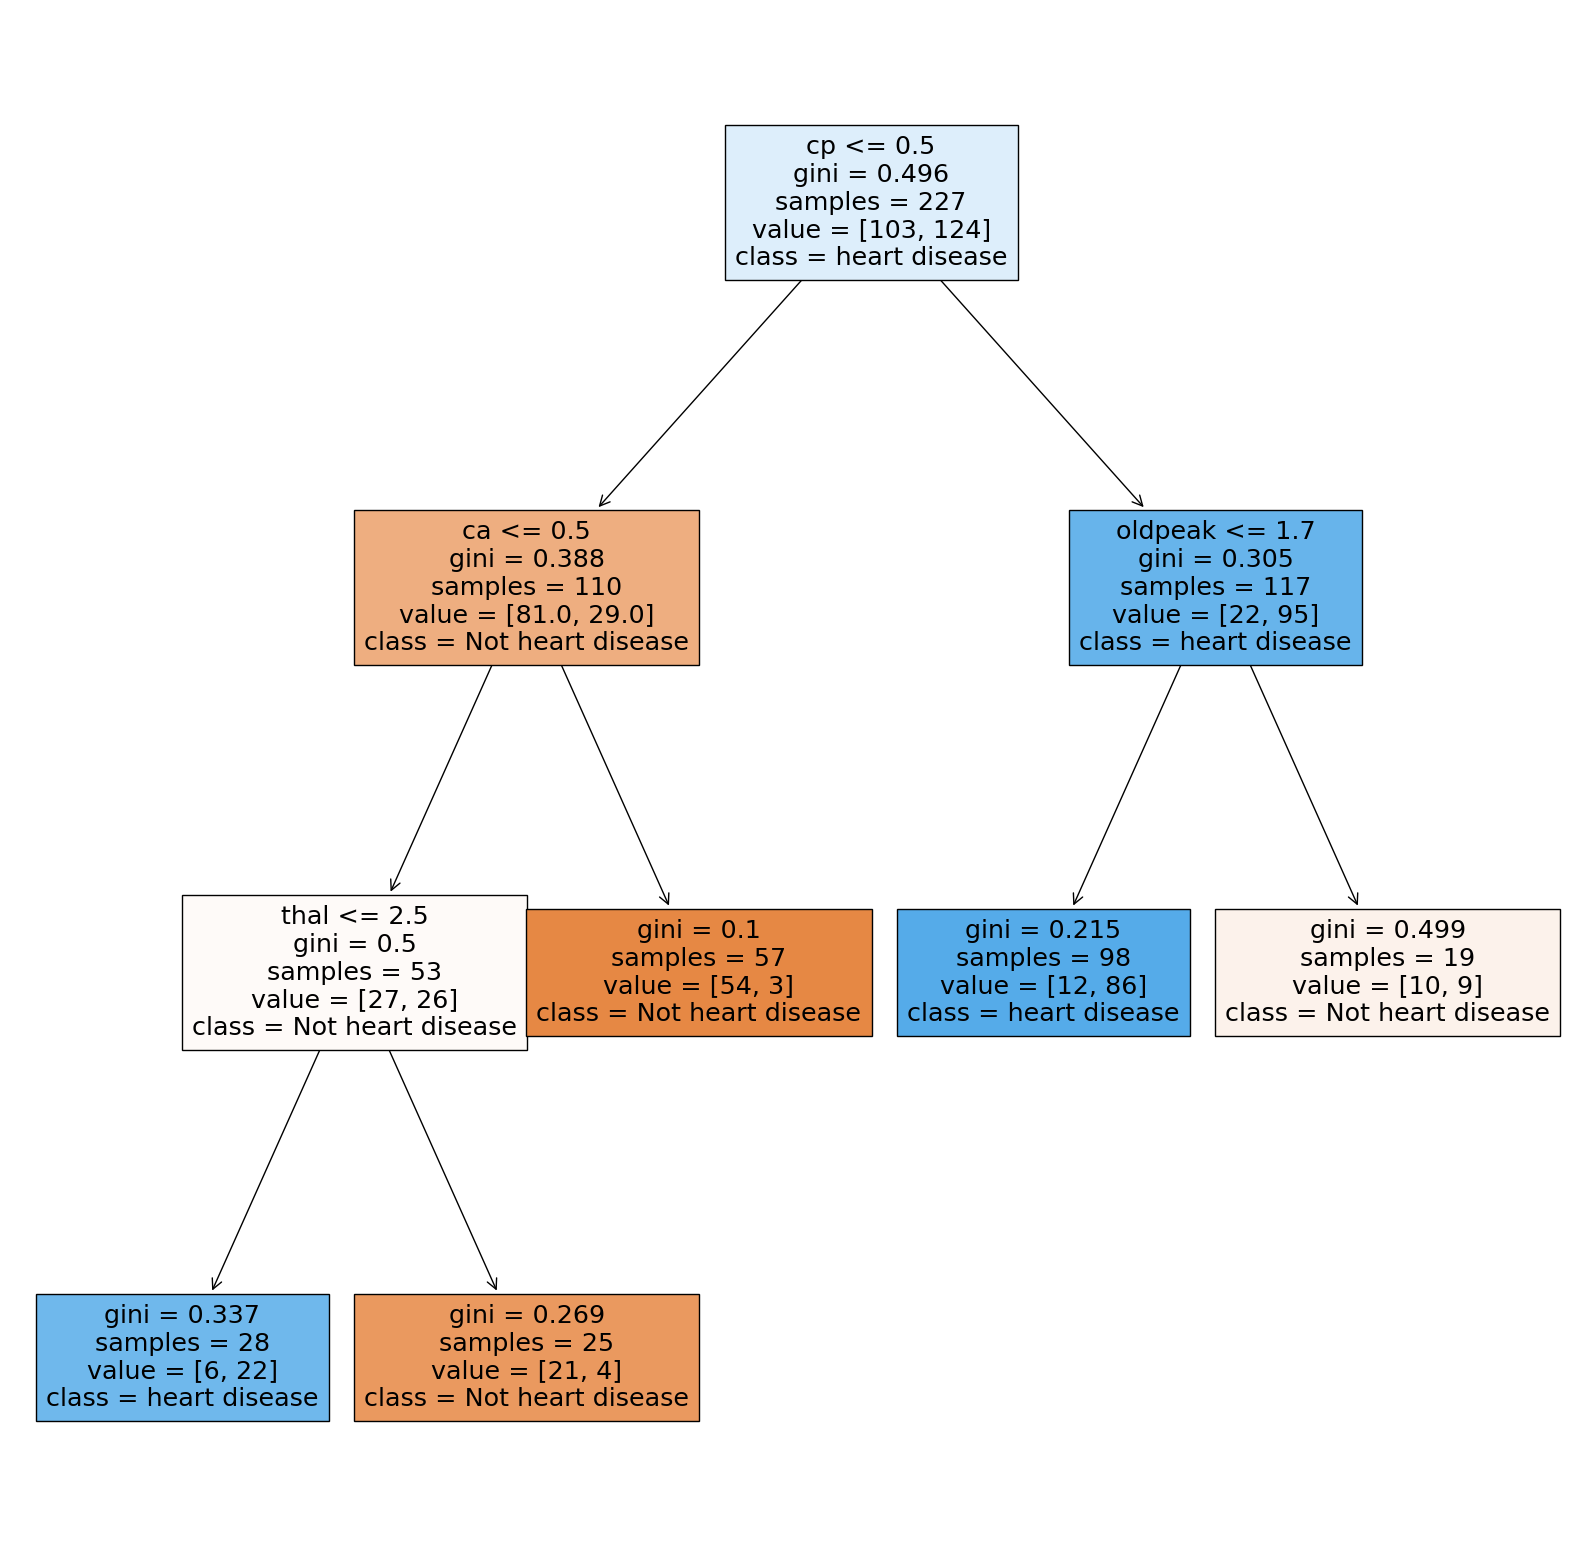

In [21]:
plt.figure(figsize=(20,20))
features = df.columns
classes = ['Not heart disease','heart disease']
tree.plot_tree(clf_,feature_names=features,class_names=classes,filled=True)
plt.show()